<a href="https://colab.research.google.com/github/Likhita-7/decisiontree-49/blob/main/Decisiontree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from math import*
import copy
from graphviz import Digraph
import random

In [139]:
datasets={'balance':['https://raw.githubusercontent.com/Likhita-7/decisiontree-49/main/balance-scale.csv','Class'],'iris':['https://raw.githubusercontent.com/Likhita-7/decisiontree-49/main/Iris.csv','Species'],'lymphography':['https://raw.githubusercontent.com/Likhita-7/decisiontree-49/main/lymph.csv','class'],'balloons':['https://raw.githubusercontent.com/Likhita-7/decisiontree-49/main/adult%2Bstretch.data.csv','inflated'],'house':['https://raw.githubusercontent.com/Likhita-7/decisiontree-49/main/house-votes-84.data.csv','republican']}


**Implementation of Train Test Split Function**

In [20]:
def train_test_split(df,test_size):
  df=df.sample(frac = 1)
  n=len(df)
  no_test_rows=int(n*test_size)
  l=list(random.sample(list(range(n)), no_test_rows))
  test=df.iloc[l]
  train=df.drop(l,axis=0)
  return train.sample(frac = 1),test.sample(frac = 1)

**Implementation of Accuracy Function**

In [21]:
def accuracy_score(y_true, y_pred):
  total_count=len(y_true)
  correct_prediction_count=0
  for i in range(total_count):
    if y_true[i]==y_pred[i]:
      correct_prediction_count+=1
  return (correct_prediction_count/total_count)*100

**Implementation of Decision Tree Algorithm**

In [22]:
class DecisionTree():
  
  ## Class Member Functions ##

  def entropy_help(p):
    return -p*log(p,2)
  
  def getEntropy(df,target_name):  
    n=df.count()[0]
    target_counts=df[target_name].value_counts().to_dict()
    s=0
    for p in target_counts.values():
      if p/n==1 or p/n==0:
        return 0
      s+=DecisionTree.entropy_help(p/n)
    # print(s)
    return s
  
  def getProbability(df,column,value):
    return df[df[column]==value].count()[0]/df.count()[0]
  
  def informationGain(df,target_name,col):
    # print("Entropy of ",col,DecisionTree.getEntropy(df,target_name))
    total_entropy=DecisionTree.getEntropy(df,target_name)
    col_vals_count=df[col].value_counts().to_dict()
    sum=0
    for value in col_vals_count:
      n=col_vals_count[value]
      # print("Entropy of ",col,value,DecisionTree.getEntropy(df[df[col]==value],target_name))
      sum+=(DecisionTree.getEntropy(df[df[col]==value],target_name)*DecisionTree.getProbability(df,col,value))
    # print("IG: ",target_name,col,total_entropy-sum)
    return total_entropy-sum

  ## Class Data Members ##

  split_functions={'IG':informationGain}
  
  ## Countructor ##
  def __init__(self,df,target_name,split_function="IG",level=-1,leaf_nodes=-1):
    self.tree=self.Tree()
    self.df=df
    self.target_name=target_name
    self.cols=list(self.df.columns)
    self.cols.remove(self.target_name)
    self.cnt=0
    self.gnodes=[]
    self.level=level
    self.leaf_nodes=leaf_nodes
    self.rules=[]
    self.output_classes=self.df[self.target_name].unique()
    if split_function in DecisionTree.split_functions:
      self.split_function=DecisionTree.split_functions[split_function]
    else:
      raise Exception("Split function not found")

  ## Instance Methods ##

  def getGraph(self):
    return self.tree.g

  def find_leaf(self,df):
    counts=df[self.target_name].value_counts().to_dict()
    return max(zip(counts.values(), counts.keys()))[1]
    
      # unique_vals=list(df[self.target_name].unique())
      # for val in unique_vals:      
      #   if df[df[self.target_name]==val].count()[0]==df.count()[0]:
      #     return val

  def construct(self):
    maxig=[-1,""]
    for i in self.cols:
      etemp=self.split_function(df,self.target_name,i)
      maxig=maxig if maxig[0]>etemp else [etemp,i]
    root=self.Node(maxig[1],maxig[0],0)
    self.tree.insert_root(root)
    c=copy.deepcopy(self.cols)
    c.remove(root.name)
    root.gname=str(root)
    self.gnodes.append(root)
    self.tree.g.node(str(root),str(root))
    self.construct_help(df,c,root)

  def construct_help(self,df,cols,parent):
    if not parent.name:
      return
    vals=list(df[parent.name].unique())
    dftemp=df

    for k in vals:
      if self.leaf_nodes!=-1 and self.tree.no_leafs>=self.leaf_nodes:
        return
      df=dftemp
      df=df[df[parent.name]==k]
      e=DecisionTree.getEntropy(df,self.target_name)

      if e==0 or parent.level==self.level-1:
        value=self.find_leaf(df)
        node=self.Node(value,1,parent.level+1)
        node.gname=str(value)
        parent.insert_child(node)
        parent.insert_edge(k)
        self.tree.no_leafs+=1
        name=value
        if not isinstance(value, str):
          name='class'
        self.tree.g.node(name+str(self.cnt),str(value))
        self.tree.g.edge(str(parent.gname),name+str(self.cnt),label=str(k))
        
        self.cnt+=1
        continue
      maxig=[-1,""]
      for i in cols:
        etemp=self.split_function(df,self.target_name,i)
        maxig=maxig if maxig[0]>etemp else [etemp,i]
      node=self.Node(maxig[1],maxig[0],parent.level+1)
      node.gname=str(node.name)
      c=copy.deepcopy(cols)
      if node.name in c:
        c.remove(node.name)
      name=str(node)

      # checking if node name already exist in graphviz code
      
      if name in self.gnodes:
        name+=str(self.cnt)
        self.cnt+=1
      else:
        self.gnodes.append(name)
      node.gname=name

      parent.insert_child(node)
      parent.insert_edge(k)

      self.tree.g.node(name,str(node))
      self.tree.g.edge(str(parent.gname),name,label=str(k))
      
      self.construct_help(df[df[parent.name]==k],c,node)
      
  def predict(self,instances,trace=False):
    node=self.tree.root
    op=[]
    if isinstance(instances,dict):
      return self.predict_help(node,instances,trace,"")
    if isinstance(instances,list):
      
      for instance in instances:
        op.append(self.predict_help(node,instance,trace,""))
    else:
      n=len(instances)
      for i in range(n):
        instance=instances.iloc[i].to_dict()
        op.append(self.predict_help(node,instance,trace,""))
    return op

  def predict_help(self,node,instance,trace,path):
    if node.name in self.output_classes:
      if trace:
        print(path+str(node))
      return node.name
    value=instance[node.name]
    try:
      path+=str(node)+" ( "+str(value)+" ) -> "
      ind=node.edges.index(value)
      return self.predict_help(node.childs[ind],instance,trace,path)
    except Exception as e:
      return "Not valid instance, path: "+path
  def get_rules(self):
    node=self.tree.root
    self.rules_help(node,str(node.name)+" -> ")
    return self.rules

  def rules_help(self,node,path):
    for n,e in zip(node.childs,node.edges):
      if n.name in self.output_classes:
        self.rules.append("{} ( {} ) {}".format(path,str(e),str(n.name)))
      self.rules_help(n,"{} ( {} ) {} -> ".format(path,str(e),str(n.name)))
  
  ## Inner classes ##
  class Node:
    ## Countructor ##
    def __init__(self,name,ig,level):
      self.name=name
      self.ig=ig
      self.childs=[]
      self.edges=[]
      self.gname=''
      self.level=level

    ## Instance Methods ##

    def insert_child(self,node):
      self.childs.append(node)

    def insert_edge(self,edge):
      self.edges.append(edge)

    def printn(self,edge=""):
      # if self.childs:
      dashes="|"+"-"*(self.level*5)
      value="( "+str(edge)+") "+str(self.gname) if edge else str(self.gname)
      # print(" "*(self.level*2+1),''.join(['-']*31))
      # print(dashes,'|{:^15} - level - {:^2} | '.format(self.gname,self.level),list(zip(self.edges,list(map(lambda x:x.gname,self.childs)))))
      # print(" "*(self.level*2+1),''.join(['-']*31))
      print(dashes,value)

    def __str__(self):
      return str(self.name)

  class Tree:

    ## Countructor ##
    def __init__(self):
      self.root=None
      self.g=Digraph(encoding='utf-8')
      self.no_leafs=0

    ## Instance Methods ##

    def insert_root(self,node):
      self.root=node

    def printt(self):
      self.print_help(self.root,"")

    def print_help(self,node,edge):
      if node:
        node.printn(edge)
        # print("(",edge,")")
      for i in range(len(node.childs)):
        self.print_help(node.childs[i],node.edges[i])

**BALANCE DATASET**

In [23]:
dataset='balance'
split_func='IG'

In [25]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [26]:
data

,Class,L-Weight,L-Distance,R-Weight,R-Distance
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5
...,...,...,...,...,...
620,L,5,5,5,1
621,L,5,5,5,2
622,L,5,5,5,3
623,L,5,5,5,4


In [27]:
data.dtypes

Class         object
L-Weight       int64
L-Distance     int64
R-Weight       int64
R-Distance     int64
dtype: object

In [28]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  438 
 Size of Test Dataset:  187


In [29]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

Class         438
L-Weight      438
L-Distance    438
R-Weight      438
R-Distance    438
dtype: int64
438


**Descion Tree Training**

In [30]:
d=DecisionTree(data,target_name,split_function=split_func)

In [31]:
d.construct()

In [32]:
print(d.tree.no_leafs)

267


In [33]:
d.get_rules()

['R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 1 ) L-Weight ->  ( 5 ) L',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 1 ) L-Weight ->  ( 4 ) B',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 1 ) L-Weight ->  ( 1 ) R',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 1 ) L-Weight ->  ( 3 ) R',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 1 ) L-Weight ->  ( 2 ) R',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 3 ) L-Weight ->  ( 5 ) L',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 3 ) L-Weight ->  ( 2 ) L',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 3 ) L-Weight ->  ( 1 ) R',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 2 ) L-Weight ->  ( 2 ) B',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 2 ) L-Weight ->  ( 3 ) L',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance ->  ( 2 ) L-Weight ->  ( 1 ) R',
 'R-Weight ->  ( 4 ) R-Distance ->  ( 1 ) L-Distance -

In [34]:
d.tree.printt()

| R-Weight
|----- ( 4) R-Distance
|---------- ( 1) L-Distance
|--------------- ( 1) L-Weight
|-------------------- ( 5) L
|-------------------- ( 4) B
|-------------------- ( 1) R
|-------------------- ( 3) R
|-------------------- ( 2) R
|--------------- ( 3) L-Weight5
|-------------------- ( 5) L
|-------------------- ( 2) L
|-------------------- ( 1) R
|--------------- ( 2) L-Weight9
|-------------------- ( 2) B
|-------------------- ( 3) L
|-------------------- ( 1) R
|-------------------- ( 5) L
|-------------------- ( 4) L
|--------------- ( 4) L-Weight15
|-------------------- ( 3) L
|-------------------- ( 1) B
|-------------------- ( 4) L
|--------------- ( 5) L
|---------- ( 2) L-Distance20
|--------------- ( 4) L-Weight21
|-------------------- ( 1) R
|-------------------- ( 3) L
|-------------------- ( 4) L
|--------------- ( 5) L
|--------------- ( 1) R
|--------------- ( 2) L-Weight27
|-------------------- ( 3) R
|-------------------- ( 4) B
|-------------------- ( 2) R
|---

**Graphical Representation of Decision Tree**

In [35]:
f = open("balance.dot", "w")
f.write(str(d.getGraph()))
f.close()

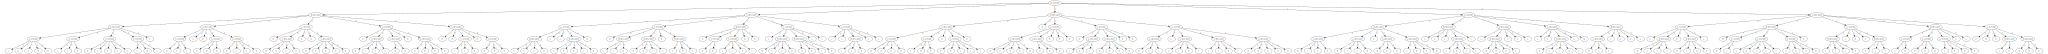

In [36]:
d.getGraph()

In [37]:
df

,Class,L-Weight,L-Distance,R-Weight,R-Distance
515,L,5,1,4,1
308,L,3,3,2,4
546,B,5,2,5,2
149,R,2,1,5,5
523,R,5,1,5,4
...,...,...,...,...,...
560,L,5,3,3,1
92,R,1,4,4,3
251,L,3,1,1,2
191,R,2,3,4,2


In [38]:
y_train_pred=d.predict(df)
print(y_train_pred)
print(df[target_name])
print(accuracy_score(df[target_name].tolist(),y_train_pred))

['L', 'L', 'B', 'R', 'R', 'B', 'L', 'R', 'R', 'L', 'L', 'L', 'R', 'L', 'R', 'L', 'L', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'B', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'B', 'R', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'B', 'R', 'R', 'B', 'R', 'L', 'L', 'L', 'R', 'R', 'R', 'R', 'L', 'B', 'R', 'L', 'R', 'R', 'L', 'L', 'L', 'L', 'R', 'B', 'R', 'L', 'L', 'L', 'B', 'L', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'R', 'B', 'R', 'L', 'L', 'B', 'L', 'L', 'R', 'L', 'R', 'R', 'R', 'B', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'R', 'L', 'L', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'L', 'B', 'L', 'L', 'B', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'B', 'B', 'L', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'B', 'R', 'L', 'B', 'L', 'R', 'L', 'R', 'L', 'B', 'B', 'L', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'B', 'L', 'R', 'L', 'L', 'L', 'L', 'R', 'L', 'L', 'L', 'L', 'L', 'L', 'R', 'L', 'R', 'L',

In [39]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

83.9572192513369

**BALOONS DATASET**

In [81]:
dataset='balloons'
split_func='IG'

In [84]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [85]:
data

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,ADULT,T
2,YELLOW,SMALL,STRETCH,CHILD,F
3,YELLOW,SMALL,DIP,ADULT,F
4,YELLOW,SMALL,DIP,CHILD,F
5,YELLOW,LARGE,STRETCH,ADULT,T
6,YELLOW,LARGE,STRETCH,ADULT,T
7,YELLOW,LARGE,STRETCH,CHILD,F
8,YELLOW,LARGE,DIP,ADULT,F
9,YELLOW,LARGE,DIP,CHILD,F


In [86]:
data.dtypes

Color       object
size        object
act         object
age         object
inflated    object
dtype: object

In [87]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  14 
 Size of Test Dataset:  6


In [88]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

Color       14
size        14
act         14
age         14
inflated    14
dtype: int64
14


**Descion Tree Training**

In [89]:
d=DecisionTree(data,target_name,split_function=split_func)

In [90]:
d.construct()

In [91]:
print(d.tree.no_leafs)

3


In [92]:
d.get_rules()

['age ->  ( ADULT ) act ->  ( DIP ) F',
 'age ->  ( ADULT ) act ->  ( STRETCH ) T',
 'age ->  ( CHILD ) F']

In [93]:
d.tree.printt()

| age
|----- ( ADULT) act
|---------- ( DIP) F
|---------- ( STRETCH) T
|----- ( CHILD) F


**Graphical Representation of Decision Tree**

In [94]:
f = open("Baloons.dot", "w")
f.write(str(d.getGraph()))
f.close()

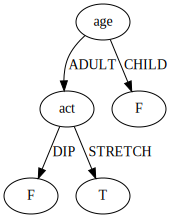

In [95]:
d.getGraph()

In [96]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


In [97]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

100.0

**IRIS DATASET**

In [98]:
dataset='iris'
split_func='IG'

In [99]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [100]:
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [101]:
data.dtypes

Id                 int64
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

In [102]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  105 
 Size of Test Dataset:  45


In [103]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

Id               105
SepalLengthCm    105
SepalWidthCm     105
PetalLengthCm    105
PetalWidthCm     105
Species          105
dtype: int64
105


**Descion Tree Training**

In [104]:
d=DecisionTree(data,target_name,split_function=split_func)

In [105]:
d.construct()

In [106]:
print(d.tree.no_leafs)

105


In [107]:
d.get_rules()

['Id ->  ( 74 ) Iris-versicolor',
 'Id ->  ( 129 ) Iris-virginica',
 'Id ->  ( 107 ) Iris-virginica',
 'Id ->  ( 130 ) Iris-virginica',
 'Id ->  ( 29 ) Iris-setosa',
 'Id ->  ( 150 ) Iris-virginica',
 'Id ->  ( 67 ) Iris-versicolor',
 'Id ->  ( 63 ) Iris-versicolor',
 'Id ->  ( 117 ) Iris-virginica',
 'Id ->  ( 34 ) Iris-setosa',
 'Id ->  ( 61 ) Iris-versicolor',
 'Id ->  ( 111 ) Iris-virginica',
 'Id ->  ( 43 ) Iris-setosa',
 'Id ->  ( 148 ) Iris-virginica',
 'Id ->  ( 90 ) Iris-versicolor',
 'Id ->  ( 97 ) Iris-versicolor',
 'Id ->  ( 5 ) Iris-setosa',
 'Id ->  ( 45 ) Iris-setosa',
 'Id ->  ( 85 ) Iris-versicolor',
 'Id ->  ( 116 ) Iris-virginica',
 'Id ->  ( 55 ) Iris-versicolor',
 'Id ->  ( 84 ) Iris-versicolor',
 'Id ->  ( 118 ) Iris-virginica',
 'Id ->  ( 122 ) Iris-virginica',
 'Id ->  ( 125 ) Iris-virginica',
 'Id ->  ( 86 ) Iris-versicolor',
 'Id ->  ( 10 ) Iris-setosa',
 'Id ->  ( 3 ) Iris-setosa',
 'Id ->  ( 76 ) Iris-versicolor',
 'Id ->  ( 92 ) Iris-versicolor',
 'Id ->  (

In [108]:
d.tree.printt()

| Id
|----- ( 74) Iris-versicolor
|----- ( 129) Iris-virginica
|----- ( 107) Iris-virginica
|----- ( 130) Iris-virginica
|----- ( 29) Iris-setosa
|----- ( 150) Iris-virginica
|----- ( 67) Iris-versicolor
|----- ( 63) Iris-versicolor
|----- ( 117) Iris-virginica
|----- ( 34) Iris-setosa
|----- ( 61) Iris-versicolor
|----- ( 111) Iris-virginica
|----- ( 43) Iris-setosa
|----- ( 148) Iris-virginica
|----- ( 90) Iris-versicolor
|----- ( 97) Iris-versicolor
|----- ( 5) Iris-setosa
|----- ( 45) Iris-setosa
|----- ( 85) Iris-versicolor
|----- ( 116) Iris-virginica
|----- ( 55) Iris-versicolor
|----- ( 84) Iris-versicolor
|----- ( 118) Iris-virginica
|----- ( 122) Iris-virginica
|----- ( 125) Iris-virginica
|----- ( 86) Iris-versicolor
|----- ( 10) Iris-setosa
|----- ( 3) Iris-setosa
|----- ( 76) Iris-versicolor
|----- ( 92) Iris-versicolor
|----- ( 9) Iris-setosa
|----- ( 36) Iris-setosa
|----- ( 77) Iris-versicolor
|----- ( 95) Iris-versicolor
|----- ( 87) Iris-versicolor
|----- ( 15) Iris-s

**Graphviz Representation of Decision Tree**

In [109]:
f = open("iris.dot", "w")
f.write(str(d.getGraph()))
f.close()

In [110]:
d.getGraph()

In [111]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


In [112]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

71.11111111111111

CONGRESS DATASET

In [113]:
dataset='house'
split_func='IG'

In [114]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [115]:
data

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
430,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
431,republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
432,republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y


In [116]:
data.dtypes

republican    object
n             object
y             object
n.1           object
y.1           object
y.2           object
y.3           object
n.2           object
n.3           object
n.4           object
y.4           object
?             object
y.5           object
y.6           object
y.7           object
n.5           object
y.8           object
dtype: object

In [117]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  304 
 Size of Test Dataset:  130


In [118]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

republican    304
n             304
y             304
n.1           304
y.1           304
y.2           304
y.3           304
n.2           304
n.3           304
n.4           304
y.4           304
?             304
y.5           304
y.6           304
y.7           304
n.5           304
y.8           304
dtype: int64
304


**Descion Tree Training**

In [119]:
d=DecisionTree(data,target_name,split_function=split_func)

In [120]:
d.construct()

In [121]:
print(d.tree.no_leafs)

24


In [122]:
d.get_rules()

['y.1 ->  ( n ) y.5 ->  ( n ) democrat',
 'y.1 ->  ( n ) y.5 ->  ( ? ) n.3 ->  ( y ) democrat',
 'y.1 ->  ( n ) y.5 ->  ( ? ) n.3 ->  ( n ) republican',
 'y.1 ->  ( n ) y.5 ->  ( ? ) n.3 ->  ( ? ) democrat',
 'y.1 ->  ( n ) y.5 ->  ( y ) democrat',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( n ) y.8 ->  ( n ) republican',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( n ) y.8 ->  ( y ) republican',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( n ) y.8 ->  ( ? ) n.1 ->  ( n ) republican',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( n ) y.8 ->  ( ? ) n.1 ->  ( y ) y.6 ->  ( n ) republican',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( n ) y.8 ->  ( ? ) n.1 ->  ( y ) y.6 ->  ( y ) democrat',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( ? ) republican',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( y ) y.4 ->  ( y ) republican',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( y ) y.4 ->  ( n ) y.7 ->  ( y ) democrat',
 'y.1 ->  ( y ) ? ->  ( n ) n.5 ->  ( y ) y.4 ->  ( n ) y.7 ->  ( ? ) republican',
 'y.1 ->  ( y ) ? ->  ( y ) n.4 ->  ( n ) n.1 ->  

In [123]:
d.tree.printt()

| y.1
|----- ( n) y.5
|---------- ( n) democrat
|---------- ( ?) n.3
|--------------- ( y) democrat
|--------------- ( n) republican
|--------------- ( ?) democrat
|---------- ( y) democrat
|----- ( y) ?
|---------- ( n) n.5
|--------------- ( n) y.8
|-------------------- ( n) republican
|-------------------- ( y) republican
|-------------------- ( ?) n.1
|------------------------- ( n) republican
|------------------------- ( y) y.6
|------------------------------ ( n) republican
|------------------------------ ( y) democrat
|--------------- ( ?) republican
|--------------- ( y) y.4
|-------------------- ( y) republican
|-------------------- ( n) y.7
|------------------------- ( y) democrat
|------------------------- ( ?) republican
|---------- ( y) n.4
|--------------- ( n) n.114
|-------------------- ( n) y.615
|------------------------- ( n) democrat
|------------------------- ( y) republican
|-------------------- ( y) n.2
|------------------------- ( n) democrat
|------------------

**Graphviz Representation of Decision Tree**

In [124]:
f = open("house.dot", "w")
f.write(str(d.getGraph()))
f.close()

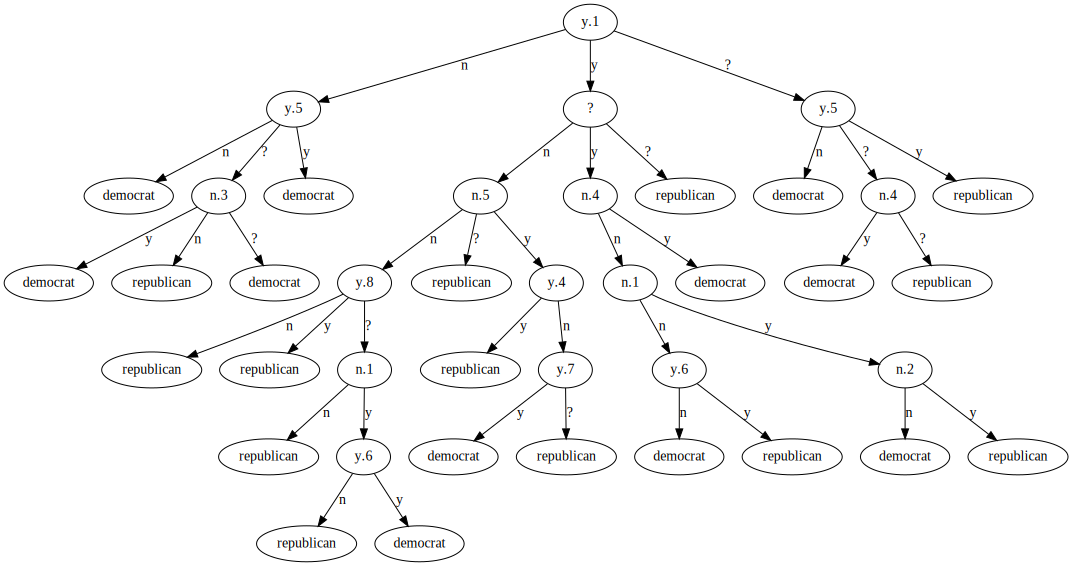

In [125]:
d.getGraph()

In [126]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


In [127]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

98.46153846153847

**Lymphography Data Set**

In [140]:
dataset='lymphography'
split_func='IG'

In [141]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [142]:
data

,lymphatics,block_of_affere,bl_of_lymph_c,bl_of_lymph_s,by_pass,extravasates,regeneration_of,early_uptake_in,lym_nodes_dimin,lym_nodes_enlar,changes_in_lym,defect_in_node,changes_in_node,changes_in_stru,special_forms,dislocation_of,exclusion_of_no,no_of_nodes_in,class
0,arched,yes,no,no,no,no,no,yes,1,4,round,lac_central,lacunar,stripped,vesicles,yes,yes,5,malign_lymph
1,displaced,yes,no,no,yes,yes,no,yes,1,3,round,lac_central,lacunar,diluted,vesicles,yes,yes,3,malign_lymph
2,deformed,no,no,no,yes,yes,yes,no,3,1,bean,lacunar,no,diluted,vesicles,no,no,7,fibrosis
3,arched,no,no,no,no,yes,no,yes,1,2,oval,lac_margin,lac_margin,drop_like,vesicles,no,yes,1,malign_lymph
4,arched,no,no,no,no,no,no,no,1,2,round,lac_margin,lac_margin,faint,vesicles,no,no,1,metastases
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,displaced,no,no,no,no,no,no,yes,1,3,round,lacunar,lacunar,coarse,chalices,yes,yes,2,metastases
144,deformed,no,no,no,no,yes,no,yes,1,4,round,lac_central,lacunar,coarse,vesicles,yes,yes,6,malign_lymph
145,deformed,yes,no,no,yes,yes,no,yes,1,2,oval,lac_central,lac_margin,diluted,chalices,yes,yes,4,malign_lymph
146,deformed,yes,no,no,no,no,no,yes,1,3,oval,lacunar,lac_central,faint,vesicles,yes,yes,3,malign_lymph


In [143]:
data.dtypes

lymphatics         object
block_of_affere    object
bl_of_lymph_c      object
bl_of_lymph_s      object
by_pass            object
extravasates       object
regeneration_of    object
early_uptake_in    object
lym_nodes_dimin     int64
lym_nodes_enlar     int64
changes_in_lym     object
defect_in_node     object
changes_in_node    object
changes_in_stru    object
special_forms      object
dislocation_of     object
exclusion_of_no    object
no_of_nodes_in      int64
class              object
dtype: object

In [144]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  104 
 Size of Test Dataset:  44


In [145]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

lymphatics         104
block_of_affere    104
bl_of_lymph_c      104
bl_of_lymph_s      104
by_pass            104
extravasates       104
regeneration_of    104
early_uptake_in    104
lym_nodes_dimin    104
lym_nodes_enlar    104
changes_in_lym     104
defect_in_node     104
changes_in_node    104
changes_in_stru    104
special_forms      104
dislocation_of     104
exclusion_of_no    104
no_of_nodes_in     104
class              104
dtype: int64
104


**Descion Tree Training**

In [146]:
d=DecisionTree(data,target_name,split_function=split_func)

In [147]:
d.construct()

In [148]:
print(d.tree.no_leafs)

49


In [149]:
d.get_rules()

['changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 7 ) metastases',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 1 ) block_of_affere ->  ( no ) special_forms ->  ( no ) metastases',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 1 ) block_of_affere ->  ( no ) special_forms ->  ( chalices ) dislocation_of ->  ( yes ) malign_lymph',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 1 ) block_of_affere ->  ( no ) special_forms ->  ( chalices ) dislocation_of ->  ( no ) metastases',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 1 ) block_of_affere ->  ( no ) special_forms ->  ( vesicles ) metastases',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 1 ) block_of_affere ->  ( yes ) metastases',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 2 ) defect_in_node ->  ( lac_central ) metastases',
 'changes_in_node ->  ( lac_margin ) no_of_nodes_in ->  ( 2 ) defect_in_node ->  ( lac_margin ) metastases',
 'changes_in_node ->  

In [150]:
d.tree.printt()

| changes_in_node
|----- ( lac_margin) no_of_nodes_in
|---------- ( 7) metastases
|---------- ( 1) block_of_affere
|--------------- ( no) special_forms
|-------------------- ( no) metastases
|-------------------- ( chalices) dislocation_of
|------------------------- ( yes) malign_lymph
|------------------------- ( no) metastases
|-------------------- ( vesicles) metastases
|--------------- ( yes) metastases
|---------- ( 2) defect_in_node
|--------------- ( lac_central) metastases
|--------------- ( lac_margin) metastases
|--------------- ( lacunar) special_forms8
|-------------------- ( vesicles) malign_lymph
|-------------------- ( chalices) metastases
|---------- ( 4) changes_in_stru
|--------------- ( diluted) malign_lymph
|--------------- ( faint) malign_lymph
|--------------- ( grainy) metastases
|---------- ( 5) malign_lymph
|---------- ( 3) changes_in_stru15
|--------------- ( drop_like) metastases
|--------------- ( stripped) malign_lymph
|--------------- ( grainy) metastases


**Graphviz Representation of Decision Tree**

In [151]:
f = open("lymphatics.dot", "w")
f.write(str(d.getGraph()))
f.close()

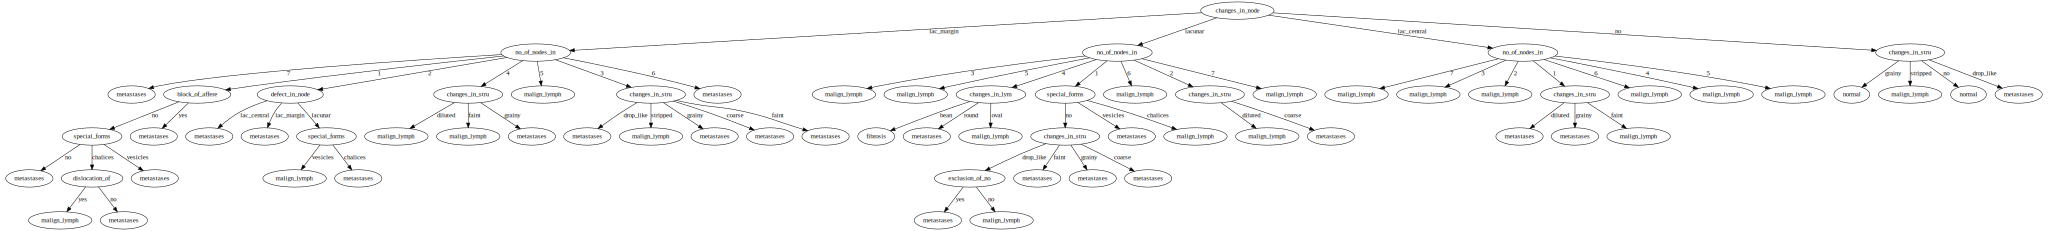

In [152]:
d.getGraph()

In [153]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


In [154]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

86.36363636363636